# Lane Line Detection
***

One important aspect of driving is for drivers to remain within their lane. This minimizes the chances of collisions with other cars. As humans, we are able to do this quite naturally. For computers, this isn't quite so easy. The first part of this is to detect driving lanes. In this project, we demonstrate one approach for detecting driving lanes using some well known computer vision techniques. Below, we describe each of these techniques in detail and show how they can be applied using a combination of Python and OpenCV to detect driving lanes.  

---

## Admin

import packages

In [1]:
# standard packages
import numpy as np
import os

# image processing packages
import cv2

# visualization packages
import matplotlib.pyplot as plt

set params

In [2]:
# show plots inline
%matplotlib inline

### General Approach 

There are a number of ways to detect driving lanes from images and the following is one such (relatively simple) approach: 

1. Convert original image to HSL
2. Isolate yellow and white areas to reduce noise
3. Combine isolated HSL with original image
4. Convert to grayscale to reduce noise
5. Apply Gaussian Blur to smoothen edge
6. Apply Canny Edge Detection to detect edges
7. Mask to show only features in our region Of interest
8. Apply Hough Transformation to find lanes
9. Separate left and right lanes
10. Find lines of best fit for both left and right lanes
11. Overlay lines over original image
12. Lane detectory with "memory"

We'll start by developing a pipeline on a series of individual images. Later we show how this can easily be extended to videos (which are really just a series of images). We will use the following sample images of 960 x 540 pixels for developing and testing our pipelines.  

In [3]:
test_img_dir = "test_images/"

original_image_names = (
    sorted(
        os.listdir(test_img_dir)
    )
)

original_image_names = list(
    map(lambda name: test_img_dir + name, 
        original_image_names))

In [4]:
def show_image_list(img_list, 
                    cols=2, 
                    fig_size=(10, 10),
                    img_labels=original_image_names, 
                    cmap=None):
    
    """
    Show a list of images
    """
    
    img_count = len(img_list)
    
    rows = np.ceil(img_count / cols)
    
    plt.figure(figsize=fig_size)
        
    for i in range(0, img_count):
        
        img_name = img_labels[i]
        
        plt.subplot(rows, cols, i+1)
        
        img = img_list[i]
                
        # no ticks on axes
        plt.xticks([])
        plt.yticks([])
        
        # plot title
        plt.title(img_name)    
        
        # show plot 
        plt.imshow(img, cmap=cmap)

    plt.tight_layout()
    plt.show()

In [5]:
def load_image(image_path): 
    """
    load images in RGB format
    """
    
    imgBGR = cv2.imread(image_path)
    
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    
    return imgRGB

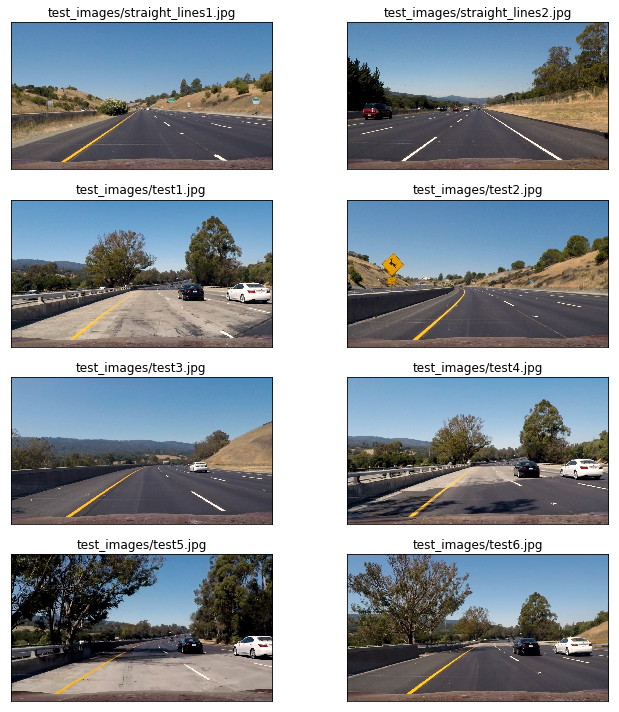

In [6]:
original_images = list(
    map(lambda img: load_image(img), 
        original_image_names)
)

show_image_list(img_list = original_images)

There are few immediately obvious challenges we need to be mindful of while building a generalized pipeline for deteting lanes in these images:  

1. While the lane lines are generally coloured white, they can also be yellow. 
2. While most of these images depict only light traffic, some of them have other cars in them and what's worse is that some cars are colored white! 
3. All of these images depict fairly straight patches of road. It is obviously possible for roads and therefore our lane lines to be curved.   

These are good things to know. Let's start building our pipeline. For testing our pipeline, we'll use just one image for now.  

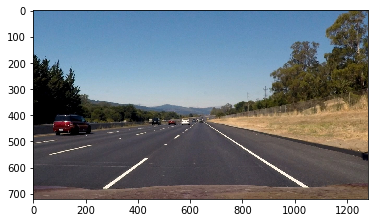

In [93]:
test_image = original_images[1]

plt.imshow(test_image)

Let's define a basic convenience function for displaying images side by side. This will be useful for comparing images created in the current step with images created in a previous step. 

In [94]:
def compare_two_images(title_a=None,
                       title_b=None,
                       image_a=None,
                       image_b=None,
                       cmap_a=None, 
                       cmap_b=None, 
                       fig_size=(10, 10)):
    
    """
    Convenience function for showing 2 images side by side 
    """
        
    plt.figure(figsize=fig_size)    

    plt.subplot(1, 2, 1)
    # no ticks on axes
    plt.xticks([])
    plt.yticks([])
    # plot title
    plt.title(title_a)    
    # show plot 
    plt.imshow(image_a, cmap=cmap_a)
    
    plt.subplot(1, 2, 2)
    # no ticks on axes
    plt.xticks([])
    plt.yticks([])
    # plot title
    plt.title(title_b)    
    # show plot 
    plt.imshow(image_b, cmap=cmap_b)
    
    plt.tight_layout()
    plt.show()

### Step 1: Convert image to HSL

There are a number of color models, below is a brief introduction to two of the most popular models in use today.   

#### RGB 

The most commonly used model is the RGB model which defines a color space in terms of three components:

- Red, which ranges from 0-255
- Green, which ranges from 0-255
- Blue, which ranges from 0-255

The RGB color model is additive i.e. Red, Green and Blue values are combined to reproduce other colors. 

<figure>
 <img src="supporting_images/rgb.png"/>
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> RGB color model </p> 

#### HLS 

The HLS color space stands for:

- Hue : the color type (such as red, blue, or yellow). Ranges from 0 to 360° in most applications (each value corresponds to one color : 0 is red, 45 is a shade of orange and 55 is a shade of yellow).
- Lightness (also Luminance or Luminosity or Intensity). Ranges from 0 to 100% (from black to white).
- Saturation : variation of the color depending on the lightness. Ranges from 0 to 100% (from the center of the black&white axis).


<figure>
 <img src="supporting_images/hsl.png"/>
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> HLS color model </p> 
     
#### HSV 

The HSV color space stands for:

- Hue : the color type (such as red, blue, or yellow). Ranges from 0 to 360° in most applications (each value corresponds to one color : 0 is red, 45 is a shade of orange and 55 is a shade of yellow).
- Saturation : variation of the color depending on the lightness. Ranges from 0 to 100% (from the center of the black&white axis).
-V: ?

<figure>
 <img src="supporting_images/hsv.png"/>
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> HSV color model </p> 


There are other color models out there too including CMYK, and YUV. Like most images however, all of our images are in RBG format. So why are we talking about other color models? We suspect that it might be easier to isolate driving lanes in other color spaces than RGB. So let's have a look at our test images in HSL.    

In [95]:
def rgb(img_rgb, channel):
    """
    extracts specified channel from RGB image
    """
    
    if channel=='r':
        img_channel = img_rgb[:,:,0] 
    if channel=='g':
        img_channel = img_rgb[:,:,1]
    if channel=='b':
        img_channel = img_rgb[:,:,2]
    if channel==None:
        img_channel = img_rgb
    
    return img_channel

In [96]:
def hls(img, channel):
    """
    converts RGB image to HSL and extracts specified channel
    """
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    if channel=='h':
        img_channel = img_hls[:,:,0] 
    if channel=='l':
        img_channel = img_hls[:,:,1]
    if channel=='s':
        img_channel = img_hls[:,:,2]
    if channel==None:
        img_channel = img_hls
    
    return img_channel

In [97]:
def hsv(img, channel):
    """
    converts RGB image to HSV and extracts specified channel
    """
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    if channel=='h':
        img_channel = img_hsv[:,:,0] 
    if channel=='s':
        img_channel = img_hsv[:,:,1]
    if channel=='v':
        img_channel = img_hsv[:,:,2]
    if channel==None:
        img_channel = img_hsv
    
    return img_channel

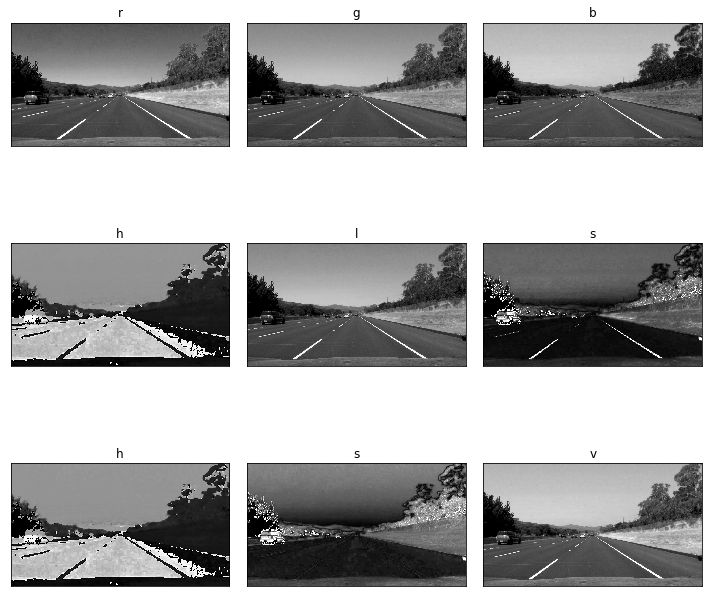

In [98]:
show_image_list(
    img_list=[
        rgb(test_image, 'r'), rgb(test_image, 'g'), rgb(test_image, 'b'), 
        hls(test_image, 'h'), hls(test_image, 'l'), hls(test_image, 's'), 
        hsv(test_image, 'h'), hsv(test_image, 's'), hsv(test_image, 'v')
    ],
    img_labels=[
        'r', 'g', 'b',
        'h', 'l', 's', 
        'h', 's', 'v'
    ], 
    cmap='gray',
    cols=3
)

s from HLS looks best, we'll go with that.  

In [99]:
hls_s_image = hls(img=test_image, channel='s')

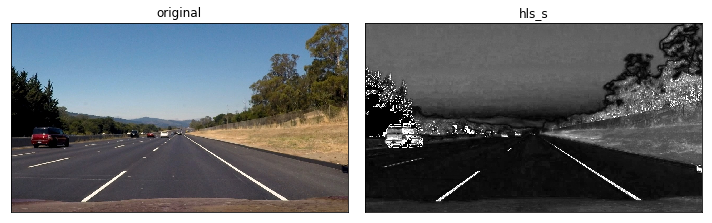

In [100]:
show_image_list(
    img_list=[
        test_image, hls_s_image, 
    ],
    img_labels=[
        'original', 'hls_s'
    ], 
    cmap='gray',
    cols=2
)

### Step 2: Apply Gaussian Blur

Gaussian blur is a pre-processing technique used for reducing noise. The OpenCV implementation of Gaussian Blur takes a integer kernel parameter which indicates the intensity of the smoothing. 

For our use case, Gaussian blur serves the purpose of smoothening edges and reducing the number of lines we detect. We really only want to focus on the most significant lines (the lane ones), not those on every object. At the same time, if we blur the images too much it will become difficult to find a line, so there's a balance involved. Through experimentation, we determined that a kernel value of 5 was appropriate for our purposes.  

In [145]:
def gaussian_blur(img, kernel_size=5):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

In [146]:
blur_image = gaussian_blur(hls_s_image)

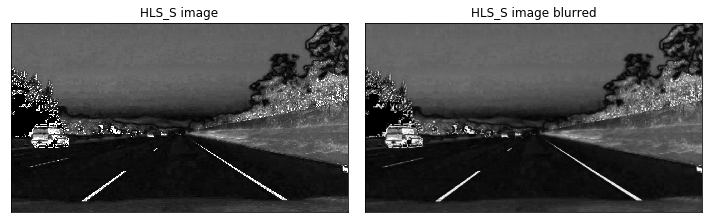

In [149]:
compare_two_images(
    image_a=hls_s_image,
    title_a='HLS_S image',
    image_b=blur_image, 
    title_b='HLS_S image blurred', 
    cmap_a='gray', 
    cmap_b='gray')

Although its a little difficult to see here, the sharp jagged edges of our lane lines have become smoother and more continuous. This should help with the next stage where we try to detect edges.  

### Step 2: Color Thresholding

In [127]:
def color_threshold(img, thresh=(50, 255)):
    """
    thresholds a given single channel image
    """
    
    binary_output = np.zeros_like(img)
    binary_output[(img > thresh[0]) & (img <= thresh[1])] = 1
    
    return binary_output

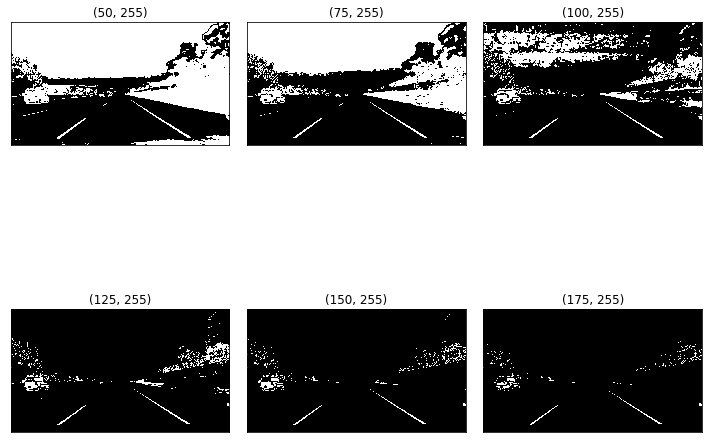

In [150]:
thresholds=[
    (50, 255),
    (75, 255),
    (100, 255),
    (125, 255),
    (150, 255),
    (175, 255)
    ]

show_image_list(
    img_list=[color_threshold(blur_image, threshold) for threshold in thresholds],
    img_labels=thresholds, 
    cmap='gray',
    cols=3
)

175, 255 it is. 

### Step 3: Gradient thresholding

There are a number of ways to do gradient thresholding.  

In [103]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    """
    expects a single channel image
    sobel_kernel must be an odd number, choose a larger odd number to smooth gradient measurements 
    """
    
    # Take the derivative in x or y given orient = 'x' or 'y'
    if orient=='x': 
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient=='y':
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return grad_binary

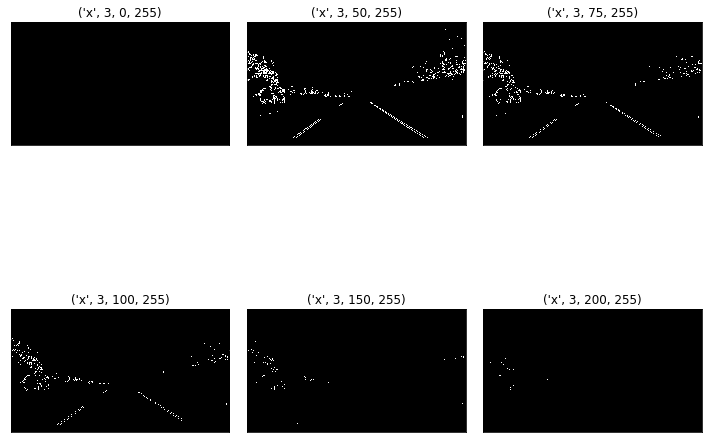

In [151]:
params=[
    ('x', 3, 0, 255),
    ('x', 3, 50, 255),
    ('x', 3, 75, 255),
    
    ('x', 3, 100, 255),
    ('x', 3, 150, 255),
    ('x', 3, 200, 255)
    ]

show_image_list(
    img_list=[
        abs_sobel_thresh(img = blur_image, 
                         orient = param[0], 
                         sobel_kernel = param[1], 
                         thresh = (param[2], param[3])
                        ) for param in params
    ],
    img_labels=params, 
    cmap='gray',
    cols=3
)

'x' orientation is useless for detecting driving lanes, no surprises there.  

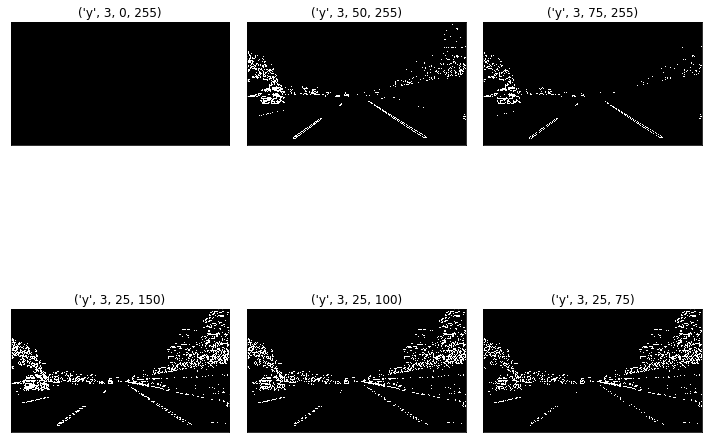

In [152]:
params=[
    ('y', 3, 0, 255),
    ('y', 3, 50, 255),
    ('y', 3, 75, 255),
    
    ('y', 3, 25, 150),
    ('y', 3, 25, 100),
    ('y', 3, 25, 75)
    ]

show_image_list(
    img_list=[
        abs_sobel_thresh(img = blur_image, 
                         orient = param[0], 
                         sobel_kernel = param[1], 
                         thresh = (param[2], param[3])
                        ) for param in params
    ],
    img_labels=params, 
    cmap='gray',
    cols=3
)

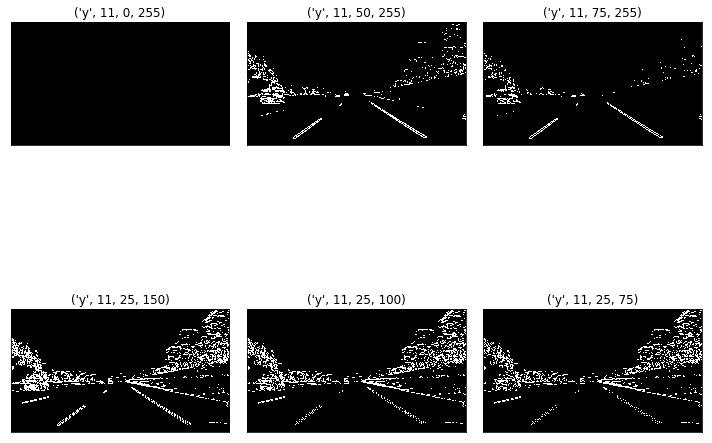

In [153]:
params=[
    ('y', 11, 0, 255),
    ('y', 11, 50, 255),
    ('y', 11, 75, 255),
    
    ('y', 11, 25, 150),
    ('y', 11, 25, 100),
    ('y', 11, 25, 75)
    ]

show_image_list(
    img_list=[
        abs_sobel_thresh(img = blur_image, 
                         orient = param[0], 
                         sobel_kernel = param[1], 
                         thresh = (param[2], param[3])
                        ) for param in params
    ],
    img_labels=params, 
    cmap='gray',
    cols=3
)

'y' orientation works well for detecting driving lanes, no surprises there. 

y,11,25,150 <- looks good

In [107]:
def mag_threshold(img, sobel_kernel=3, thresh=(0, 255)):
    """
    expects a single channel image
    sobel_kernel must be an odd number, choose a larger odd number to smooth gradient measurements
    """
    
    # Take the derivative in x and y
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # Take the absolute value of the derivative or gradient
    abs_sobel_xy = np.sqrt(np.square(sobel_x) + np.square(sobel_y))

    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel_xy/np.max(abs_sobel_xy))
    
    # Create a mask of 1's where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return mag_binary

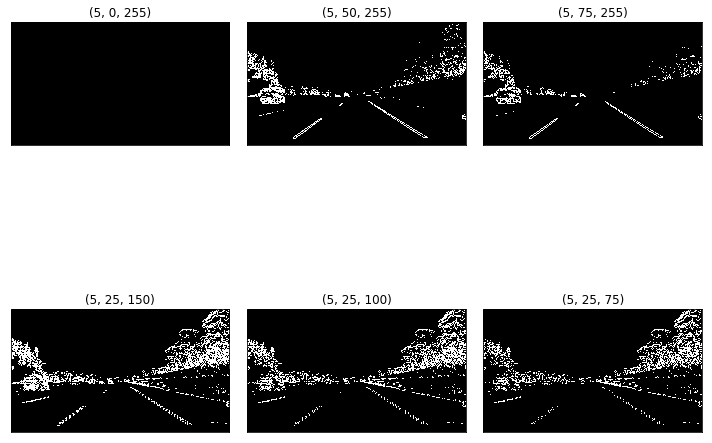

In [154]:
params=[
    (5, 0, 255),
    (5, 50, 255),
    (5, 75, 255),
    (5, 25, 150),
    (5, 25, 100),
    (5, 25, 75)
    ]

show_image_list(
    img_list=[
        mag_threshold(
            img = blur_image, 
            sobel_kernel = param[0], 
            thresh = (param[1], param[2])
        ) for param in params
    ],
    img_labels=params, 
    cmap='gray',
    cols=3
)

5,25,150 <- looks good

In [109]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    """
    expects a single channel image
    sobel_kernel must be an odd number, choose a larger odd number to smooth gradient measurements
    """
    
    # Take the derivative in x and y
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the x and y gradients
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    
    # Calculate the direction of the gradient 
    abs_grad_dir = np.arctan2(abs_sobel_y, abs_sobel_x)
    
    # Create a mask of where direction thresholds are met
    dir_binary = np.zeros_like(abs_grad_dir)
    dir_binary[(abs_grad_dir >= thresh[0]) & (abs_grad_dir <= thresh[1])] = 1
    
    return dir_binary

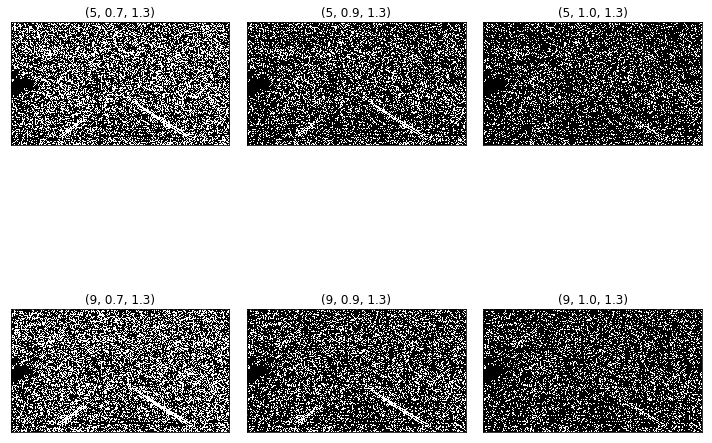

In [155]:
params=[
    (5, 0.7, 1.3),
    (5, 0.9, 1.3),
    (5, 1.0, 1.3),
    (9, 0.7, 1.3),
    (9, 0.9, 1.3),
    (9, 1.0, 1.3),
    ]

show_image_list(
    img_list=[
        dir_threshold(
            img = blur_image, 
            sobel_kernel = param[0], 
            thresh = (param[1], param[2])
        ) for param in params
    ],
    img_labels=params, 
    cmap='gray',
    cols=3
)

In [156]:
def combine_thresholds(img1, img2, img3): 
    """
    combines images thresholded in different ways
    """
    
    combined = np.zeros_like(img1)
    
    combined[(img1 == 1) & (img2 == 1) & (img3 == 1)] = 1
    
    return combined

In [157]:
def combine_thresholds(images): 
    """
    combines images thresholded in different ways
    """
    
    combined = np.zeros_like(images[1])
    
    length = len(images)
    
    if length==2:
        combined[(images[0]==1) & (images[1]==1)] = 1
        
    if length==3:
        combined[(images[0]==1) & 
                 (images[1]==1) &
                 (images[2]==1)
                ] = 1
        
    if length==4:
        combined[(images[0]==1) & 
                 (images[1]==1) &
                 (images[2]==1) &
                 (images[3]==1)
                ] = 1
        
    if length==5:
        combined[(images[0]==1) & 
                 (images[1]==1) &
                 (images[2]==1) &
                 (images[3]==1) &
                 (images[4]==1)
                ] = 1
        
    return combined

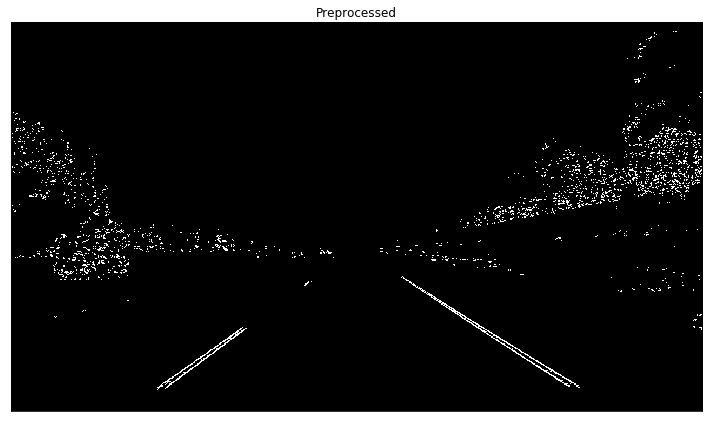

In [158]:
params=[
    (color_threshold(
        img=blur_image, 
        thresh=(100,255)
    ), 
     abs_sobel_thresh(
        img = blur_image, 
        orient = 'y', 
        sobel_kernel = 3, 
        thresh = (25, 225)
    ), 
     mag_threshold(
         img = blur_image, 
         sobel_kernel = 11, 
         thresh = (20, 250)
     ), 
     dir_threshold(
         img = blur_image, 
         sobel_kernel = 15, 
         thresh = (0.7, 1.3)
     )
    )
]

show_image_list(
    img_list=[
        combine_thresholds(
            images = [param[0], param[1],  param[2], param[3]]
        ) for param in params
    ],
    img_labels=['Preprocessed'], 
    cmap='gray',
    cols=1
)

This is looking pretty good.  

In [161]:
threshold_image = combine_thresholds(
    images = [
        color_threshold(
        img=blur_image, 
        thresh=(100,255)
    ), 
     abs_sobel_thresh(
        img = blur_image, 
        orient = 'y', 
        sobel_kernel = 3, 
        thresh = (25, 225)
    ), 
     mag_threshold(
         img = blur_image, 
         sobel_kernel = 11, 
         thresh = (20, 250)
     ), 
     dir_threshold(
         img = blur_image, 
         sobel_kernel = 15, 
         thresh = (0.7, 1.3)
     )
    ]
)

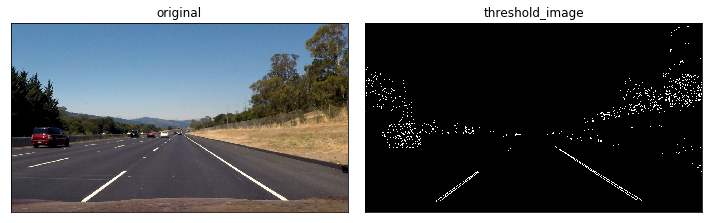

In [162]:
show_image_list(
    img_list=[
        test_image, threshold_image, 
    ],
    img_labels=[
        'original', 'threshold_image'
    ], 
    cmap='gray',
    cols=2
)

## Step 5: Camera calibration

In [213]:
camera_cal_img_dir = "camera_cal/"

camera_cal_image_names = (
    sorted(
        os.listdir(camera_cal_img_dir)
    )
)

camera_cal_image_paths = list(
    map(lambda name: camera_cal_img_dir + name, 
        camera_cal_image_names))

In [230]:
camera_cal_images = list(
    map(lambda img: load_image(img), 
        camera_cal_image_paths)
)

In [231]:
# show_image_list(
#     img_list = camera_cal_images,
#     img_labels = camera_cal_image_names, 
#     cols=5
# )

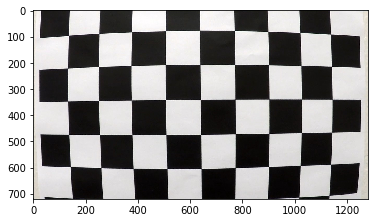

In [232]:
plt.imshow(camera_cal_images[0])

In [215]:
dims = (9,6)

gray_camera_cal_images = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in camera_cal_images]
chessboard_corners = [cv2.findChessboardCorners(image, dims, None) for image in gray_camera_cal_images]

In [238]:
# draw chessboard corners
chessboard_camera_cal_images = [
    (cv2.drawChessboardCorners(
        camera_cal_images[i], 
        dims, 
        chessboard_corners[i][::-1]
    ) for i in range(len(camera_cal_images))
    )
]

In [239]:
# show_image_list(
#     img_list = [
#         cv2.drawChessboardCorners(
#             camera_cal_images[i], 
#             dims, 
#             *chessboard_corners[i][::-1]
#         ) for i in range(len(camera_cal_images))],
#     img_labels = camera_cal_image_names, 
#     cols=5
# )

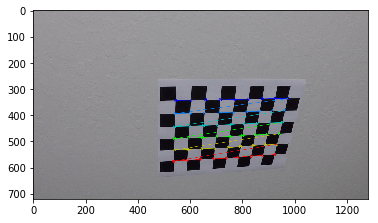

In [246]:
cv2.drawChessboardCorners(
    camera_cal_images[1], 
    dims, 
    *chessboard_corners[1][::-1])

plt.imshow(camera_cal_images[1])

In [220]:
objp = np.zeros(
    (np.prod(dims), 3), 
    np.float32
)

objp[:,:2] = np.mgrid[0:dims[0], 0:dims[1]].T.reshape(-1,2)

objpoints = [
    objp for corner_set in chessboard_corners if corner_set[0]
]

imgpoints = [
    corner_set[1] for corner_set in chessboard_corners if corner_set[0]
]

In [221]:
# Calibrate the camera
ret, mtx, dist, rvecs, tvecs = (
    cv2.calibrateCamera(
        objpoints, 
        imgpoints, 
        gray_camera_cal_images[0].shape[::-1], 
        None, 
        None)
)

In [225]:
# undistort images
undistorted_camera_cal_images = [
    (cv2.undistort(
        img, 
        mtx, 
        dist, 
        None, 
        mtx)
    ) for img in camera_cal_images
]

In [226]:
# show_image_list(
#     img_list = undistorted_camera_cal_images,
#     img_labels = camera_cal_image_names, 
#     cols=5
# )

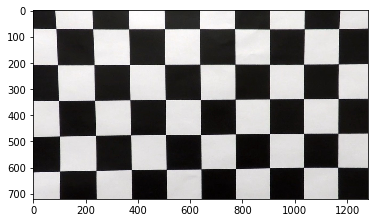

In [227]:
plt.imshow(undistorted_camera_cal_images[0])

## Step 6: Perspective Transform

In [ ]:
# Compute the perspective transform, M, given source and destination points:

M = cv2.getPerspectiveTransform(src, dst)

# Compute the inverse perspective transform:

Minv = cv2.getPerspectiveTransform(dst, src)

# Warp an image using the perspective transform, M:

warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

### Step 6 Detect edges 

Using canny edge detection algorithm. 

In [159]:
def canny(img, low_threshold=50, high_threshold=150):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

In [26]:
edges_image = canny(img=blur_image)

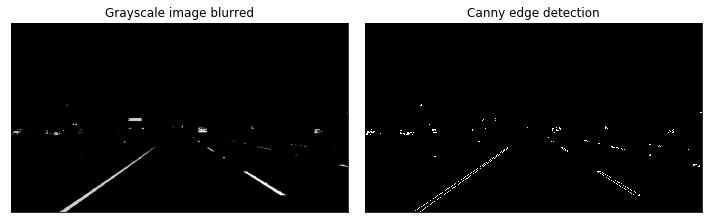

In [27]:
compare_two_images(
    image_a=blur_image, 
    title_a='Grayscale image blurred', 
    image_b=edges_image,
    title_b='Canny edge detection',
    cmap_a='gray', 
    cmap_b='gray'
)

Despite the smoothening that we did, the edges we've detected are broken rather than continuous lines.  

### Step 7: Isolate region of interest 

Reduce noise even further. 

In [28]:
def vertices(img, ):

    imshape = img.shape
    
    height = imshape[0]
    width = imshape[1]
    
    # Define a quadrilateral
    vert = np.array([[(0, imshape[0]),
                     (450, 320), 
                     (490, 320), 
                     (imshape[1], imshape[0])]], 
                   dtype=np.int32)
    
#     region_bottom_left = (200, 680)
#     region_top_left = (600, 450)
#     region_top_right = (750, 450)
#     region_bottom_right = (1100, 650)
    
#     vert = np.array([[region_bottom_left , 
#                       region_top_left, 
#                       region_top_right, 
#                       region_bottom_right]], 
#                     dtype=np.int32)
    
    return vert

In [29]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [30]:
masked_image = region_of_interest(img=edges_image, 
                                  vertices=vertices(edges_image))

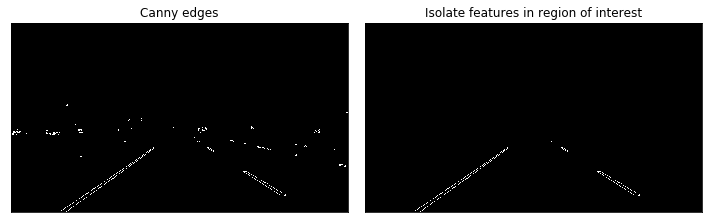

In [31]:
compare_two_images(image_a=edges_image, 
                   title_a='Canny edges', 
                   image_b=masked_image,
                   title_b='Isolate features in region of interest',
                   cmap_a='gray', 
                   cmap_b='gray')

### Step 8: Apply Hough Transformation

In [32]:
def hough_lines(img, 
                rho=1, 
                theta=np.pi/180, 
                threshold=1, 
                min_line_len=1, 
                max_line_gap=1):
    """
    Params:
        img = output of a Canny transform.
        rho =  distance resolution in pixels of the Hough grid
        theta = angular resolution in radians of the Hough grid 
        threshold = minimum number of votes (intersections in Hough grid cell)     
        min_line_length = minimum number of pixels making up a line
        max_line_gap = maximum gap in pixels between connectable line segments 
        
    Returns:
        Extracts lines
        
    """
    
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    return lines

In [33]:
def extract_left_right_x_y(img, lines):
    """
    Extrapolate detected line segments    
    """ 
    
    # image mid point
    mid_point_x = np.int(img.shape[1]/2)

    # initialize empty lists
    left_x = []
    left_y = []
    
    right_x = []
    right_y = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            
            delta_x = x2-x1
            delta_y = y2-y1
            
            if delta_x==0:
                continue
            if delta_y==0:
                continue
                
            slope = delta_y/delta_x
            
            # threshold slope value
            epsilon = 0.1
            
            if abs(slope) <= epsilon:
                continue
            
            if slope < 0 and x1 < mid_point_x and x2 < mid_point_x:
                left_x.append(x1)
                left_x.append(x2)
                left_y.append(y1)
                left_y.append(y2)
                
            elif x1 >= mid_point_x and x2 >= mid_point_x:
                right_x.append(x1)
                right_x.append(x2)
                right_y.append(y1)
                right_y.append(y2)
                
    return left_x, left_y, right_x, right_y

In [34]:
def line_formula(x, y):
    
    slope, intercept = np.polyfit(x=x, y=y, deg=1)
    
    return (slope, intercept)

In [35]:
def line_x_y(img, m, b):
    
    line_y_limit = np.int(img.shape[0]*(7/10))
    
    y1 = line_y_limit
    x1 = np.int((y1-b)/m)
    
    y2 = img.shape[0]
    x2 = np.int((y2-b)/m)
    
    return x1, y1, x2, y2

In [36]:
def draw_lines(img, color=[255, 0, 0], thickness=5):   
    
    lines = hough_lines(img=img)
    
    left_x, left_y, right_x, right_y = extract_left_right_x_y(img=img, lines=lines)
    
    left_m, left_b = line_formula(x=left_x, y=left_y)
    right_m, right_b = line_formula(x=right_x, y=right_y)
    
    left_x1, left_y1, left_x2, left_y2 = line_x_y(img=img, m=left_m, b=left_b)
    right_x1, right_y1, right_x2, right_y2 = line_x_y(img=img, m=right_m, b=right_b)

    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    cv2.line(line_img, (left_x1, left_y1), (left_x2, left_y2), color, thickness)
    cv2.line(line_img, (right_x1, right_y1), (right_x2, right_y2), color, thickness)
    
    return line_img

In [37]:
hough_line_image = draw_lines(img=masked_image)

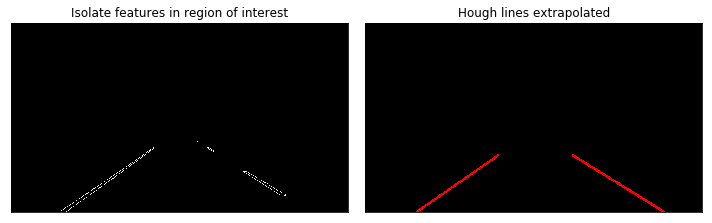

In [38]:
compare_two_images(image_a=masked_image,
                   title_a='Isolate features in region of interest',
                   image_b=hough_line_image, 
                   title_b='Hough lines extrapolated', 
                   cmap_a='gray', 
                   cmap_b='gray')

### Step 9: Overlay lines over original image 


In [39]:
def weighted_img(img, initial_img, α=0.5, β=0.7, λ=0):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [40]:
lines_overlaid_image = weighted_img(img=hough_line_image,
                                    initial_img=test_image)

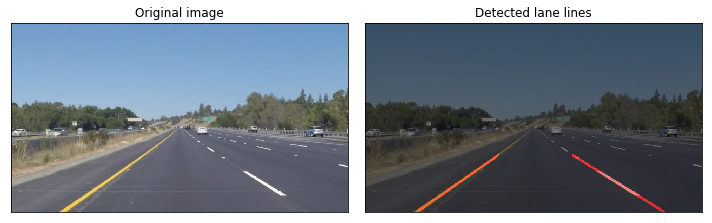

In [41]:
compare_two_images(image_a=test_image,
                   title_a='Original image',
                   image_b=lines_overlaid_image, 
                   title_b='Detected lane lines')

There is our final result.  

## Testing on Images

Now let's combine all of the above functions into one with our best parameters.  

In [42]:
def process_image(image, show_plots=False):
    """
    One function to rule them all!
    """
    
    # convert image to hsl
    image_hsl = filter_img_hsl(image)

    # convert image to gray scale
    image_gray = grayscale(image_hsl)

    # Define a kernel size and apply Gaussian smoothing
    blur_gray = gaussian_blur(img=image_gray)

    # apply canny edge detection
    edges = canny(img=blur_gray)

    # isolate region of interest
    masked = region_of_interest(img=edges, 
                                vertices=vertices(edges))

    # plot left and right lines
    hough_lines = draw_lines(img=masked)
    
    # overlay lines over image
    color_edges_overlaid = weighted_img(img=hough_lines,
                                        initial_img=image)
        
    if show_plots==True:
        plt.imshow(image)
        plt.show()
        plt.imshow(image_hsl)
        plt.show()
        plt.imshow(image_gray, cmap='gray')
        plt.show()
        plt.imshow(blur_gray, cmap='gray')
        plt.show()
        plt.imshow(edges, cmap='gray')
        plt.show()
        plt.imshow(masked, cmap='gray')
        plt.show()
        plt.imshow(color_edges)
        plt.show()
        plt.imshow(color_edges_overlaid)
        plt.show()
    else: 
        #return np.concatenate((image_gray, masked), axis=1)
        #return np.hstack((image_gray, masked))
        return color_edges_overlaid

Lets test our function on all the images to see how well it worked.  

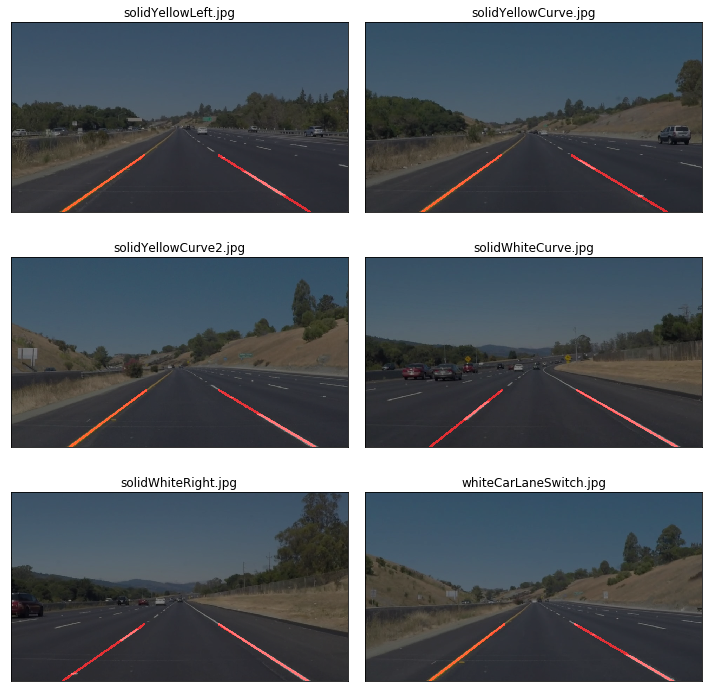

In [43]:
all_test_images = list(map(lambda img: process_image(img, show_plots=False), 
                           original_images))

show_image_list(img_list=all_test_images)

### Test on Videos

Drawing lanes over images is pretty cool but drawing lanes over video is awesome!

We'll test our solution on 3 different videos, ordered below by difficulty:

1. `solidWhiteRight.mp4`

2. `solidYellowLeft.mp4`

3. `challenge.mp4`

In [44]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

We'll try the one with the solid white lane on the right first. This is a fairly simple video. 

In [45]:
white_output = 'test_videos_output/solidWhiteRight.mp4'

clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")

white_clip = clip1.fl_image(process_image)

%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:03<00:00, 60.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.72 s, sys: 216 ms, total: 2.94 s
Wall time: 4.06 s


In [46]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [47]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'

clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')

yellow_clip = clip2.fl_image(process_image)

%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:11<00:00, 57.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 8.32 s, sys: 468 ms, total: 8.78 s
Wall time: 12.2 s


In [48]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

Lastly, we'll try the challenge video.  

In [49]:
challenge_output = 'test_videos_output/challenge.mp4'

clip3 = VideoFileClip('test_videos/challenge.mp4')

challenge_clip = clip3.fl_image(process_image)

%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:07<00:00, 31.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 5.38 s, sys: 240 ms, total: 5.62 s
Wall time: 8.61 s


In [50]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

Humm the lines in our videos are quite jerky. Let's try and fix that. 

### Step 10: Lane Detector With Memory

As previously mentioned, a video is simply a sequence of images. It is therefore possible to use the information from previous frames to smoothen the lines that we trace on the road and take corrective steps if at frame t our computed lines differ disproportionately from the mean of line slopes and intercepts we computed from frame t-1.  

To do this, we will need to add a 'memory' feature into our pipeline. We'll use a standard Python deque to store the last N computed line coefficients.  

In [51]:
from collections import deque

def create_coefficients_list(length=5):
    return deque(maxlen=length)

In [52]:
def one_to_three_channel(og_img, one_channel_img): 
    
    three_channel_img = np.zeros_like(og_img)
    three_channel_img[:,:,0] = one_channel_img
    three_channel_img[:,:,1] = one_channel_img
    three_channel_img[:,:,2] = one_channel_img
                         
    return three_channel_img

In [53]:
class LaneDetectorWithMemory:
    
    def __init__(self):
        
        self.left_lane_coefficients  = create_coefficients_list()
        self.right_lane_coefficients = create_coefficients_list()
        
        self.previous_left_lane_coefficients = None
        self.previous_right_lane_coefficients = None
    
    
    
    def mean_coefficients(self, 
                          coefficients_queue, 
                          axis=0):
        
        if len(coefficients_queue)==0:
            
            mean = [0, 0]
        
        else:
            
            mean = np.mean(coefficients_queue, axis=axis)
        
        return mean
    
    
    def determine_line_coefficients(self, 
                                    stored_coefficients, 
                                    current_coefficients, 
                                    max_slope_diff=0.1,
                                    max_intercept_diff=10):
        
        if len(stored_coefficients)==0:
            
            stored_coefficients.append(current_coefficients) 
            
            return current_coefficients
        
        mean = self.mean_coefficients(stored_coefficients)
        abs_slope_diff = abs(current_coefficients[0] - mean[0])
        abs_intercept_diff = abs(current_coefficients[1] - mean[1])        
        
        if abs_slope_diff > max_slope_diff or abs_intercept_diff > max_intercept_diff:
            
            return mean
        
        else:
            
            # Save our coefficients and returned a smoothened one
            stored_coefficients.append(current_coefficients)
            
            return self.mean_coefficients(stored_coefficients)
    
    
    def lane_detection_pipeline(self, img):
        
        # convert image to hsl
        image_hsl = filter_img_hsl(img)

        # convert image to gray scale
        image_gray = grayscale(image_hsl)

        # Define a kernel size and apply Gaussian smoothing
        blur_gray = gaussian_blur(img=image_gray)

        # apply canny edge detection
        edges = canny(img=blur_gray)

        # isolate region of interest
        masked = region_of_interest(img=edges, 
                                    vertices=vertices(edges))

        lines = hough_lines(img=masked)
    
        left_x, left_y, right_x, right_y = extract_left_right_x_y(img=img, lines=lines)

        left_m, left_b = line_formula(x=left_x, y=left_y)
        right_m, right_b = line_formula(x=right_x, y=right_y)

        smoothed_left_lane_coefficients = (self
                                           .determine_line_coefficients(
                                               self.left_lane_coefficients, 
                                               [left_m, left_b]
                                           )
                                          )

        smoothed_right_lane_coefficients = (self
                                            .determine_line_coefficients(
                                                self.right_lane_coefficients, 
                                                [right_m, right_b]
                                            )
                                           )

        left_m = smoothed_left_lane_coefficients[0]
        left_b = smoothed_left_lane_coefficients[1]
        
        right_m = smoothed_right_lane_coefficients[0]
        right_b = smoothed_right_lane_coefficients[1]

        left_x1, left_y1, left_x2, left_y2 = line_x_y(img=img, m=left_m, b=left_b)
        right_x1, right_y1, right_x2, right_y2 = line_x_y(img=img, m=right_m, b=right_b)

        line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

        cv2.line(line_img, 
                 (left_x1, left_y1), 
                 (left_x2, left_y2), 
                 color=[255, 0, 0], 
                 thickness=5)
        
        cv2.line(line_img, 
                 (right_x1, right_y1), 
                 (right_x2, right_y2), 
                 color=[255, 0, 0], 
                 thickness=5)

        # overlay lines over image
        color_edges_overlaid = weighted_img(img=line_img,
                                            initial_img=img)
        
        blur_gray_3_channel = one_to_three_channel(og_img=img, 
                                                   one_channel_img=blur_gray)
        
        masked_3_channel = one_to_three_channel(og_img=img, 
                                                one_channel_img=masked)
        
        # arrange images
        top_row = np.concatenate((img, blur_gray_3_channel), axis=1)
        bottom_row = np.concatenate((masked_3_channel, color_edges_overlaid), axis=1)
        all_rows = np.concatenate((top_row, bottom_row), axis=0)
        
        # return final image
        return all_rows

### Test on Videos

Let's try testing our new function that has some "memory."

We'll try the one with the solid white lane on the right first. This is a fairly simple video. 

In [54]:
detector = LaneDetectorWithMemory()

white_output = 'test_videos_output/solidWhiteRight_with_memory.mp4'

clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")

white_clip = clip1.fl_image(detector.lane_detection_pipeline)

%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight_with_memory.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight_with_memory.mp4


100%|█████████▉| 221/222 [00:07<00:00, 29.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight_with_memory.mp4 

CPU times: user 4.01 s, sys: 320 ms, total: 4.33 s
Wall time: 8.44 s


In [55]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [56]:
detector = LaneDetectorWithMemory()

yellow_output = 'test_videos_output/solidYellowLeft_with_memory.mp4'

clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')

yellow_clip = clip2.fl_image(detector.lane_detection_pipeline)

%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft_with_memory.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft_with_memory.mp4


100%|█████████▉| 681/682 [00:22<00:00, 30.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft_with_memory.mp4 

CPU times: user 12 s, sys: 1 s, total: 13 s
Wall time: 23.5 s


In [57]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

Lastly, we'll try the challenge video.  

In [58]:
detector = LaneDetectorWithMemory()

challenge_output = 'test_videos_output/challenge_with_memory.mp4'

clip3 = VideoFileClip('test_videos/challenge.mp4')

challenge_clip = clip3.fl_image(detector.lane_detection_pipeline)

%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge_with_memory.mp4
[MoviePy] Writing video test_videos_output/challenge_with_memory.mp4


100%|██████████| 251/251 [00:16<00:00, 16.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_with_memory.mp4 

CPU times: user 7.41 s, sys: 648 ms, total: 8.06 s
Wall time: 17.9 s


In [59]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

Naturally, you could run this pipeline against any other video as well. 